## Feature selection

Boruta is an advanced feature selection method that uses Random Forest as a base algorithm. Its goal is to identify all relevant features in a dataset, including those that might have a weaker impact on the model's predictive power but are still significant. It is particularly useful for datasets with many features where traditional methods of feature selection (such as mutual information or simple feature importance) might miss some important variables.


The main steps of the Boruta algorithm are:

Create Shadow Features:

For each feature in the dataset, create a shadow feature by randomly permuting (shuffling) the feature’s values. This step helps in understanding how important the real features are compared to random noise.
For example, if you have 10 original features, Boruta will create 10 shadow features.
Train Random Forest:

A Random Forest model is trained using the original features along with the shadow features. This model is used to rank the importance of each feature based on how it improves model performance.
Ranking Features:

The importance of each feature is determined by how much it contributes to reducing the impurity (e.g., Gini impurity) in the Random Forest. The higher the feature's contribution to impurity reduction, the more important the feature is considered.
Feature Comparison:

Each original feature is compared against its corresponding shadow feature’s importance. If the original feature has higher importance than its shadow feature, it is considered relevant.
Features are ranked based on their importance, and shadow features are always considered irrelevant.
Feature Elimination:

Boruta eliminates irrelevant features and keeps features that have higher importance than the shadow features. A feature is removed if its importance is significantly less than the highest shadow feature.
Iteration:

This process is repeated multiple times (usually several hundred iterations) to refine the ranking of features. The final set of selected features is determined based on consistent importance across the iterations.
Final Decision:

Once the algorithm has iterated enough, it returns a final list of features that are either:
Confirmed: Features that are significantly more important than their shadow counterparts.
Rejected: Features that are consistently less important than their shadow counterparts.
Tentative: Features that have mixed importance but may be relevant depending on the model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [ ]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,1140,0,84.5123,1,25.0,0.150000,169.300000,0.610000,223.340000,36.000000,...,227.925000,0.495000,223.250000,27.445000,665.065000,2.725000,-516.185000,2.638340,2397.0,3164.85
1,1051,1,75.3699,1,26.0,0.097733,175.103337,0.562332,197.321714,42.533788,...,222.355754,0.500577,218.584302,30.381415,651.981453,3.154282,2595.481588,3.146500,1662.5,2648.30
2,15,0,80.9068,0,29.0,0.100000,161.280000,0.540000,174.530000,35.940000,...,221.760000,0.445000,NaN,30.565000,NaN,3.120000,4287.780000,2.897730,2188.0,3602.50
3,680,0,77.8932,0,28.0,0.110000,235.890000,0.510000,231.560000,41.660000,...,217.450000,0.540000,236.750000,30.465000,729.545000,3.010000,-741.895000,2.734850,2292.5,3267.45
4,324,1,75.3534,1,24.0,0.140000,192.290000,0.550000,218.500000,35.280000,...,269.565000,0.390000,219.405000,26.560000,608.050000,2.565000,456.550000,2.444245,1082.0,2550.50


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [8]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 22), (158, 22))

In [9]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	10
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	10
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	10
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	10
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	9
Iterat

BorutaPy(estimator=RandomForestClassifier(n_estimators=46,
                                          random_state=RandomState(MT19937) at 0x2587E493840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2587E493840, verbose=2)

In [10]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(sel.support_)):
    if sel.support_[i]:
        print("Passes the test: ", X_train_t.columns[i],
              " - Ranking: ", sel.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train_t.columns[i], " - Ranking: ", sel.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:  Gender  - Ranking:  13
Passes the test:  Ageatscreening  - Ranking:  1
Passes the test:  MMSE0m  - Ranking:  1
Doesn't pass the test:  HipsASMbaseline  - Ranking:  4
Passes the test:  HipsContrastbaseline  - Ranking:  1
Doesn't pass the test:  HipsCorelationbaseline  - Ranking:  12
Doesn't pass the test:  HipsVariancebaseline  - Ranking:  3
Doesn't pass the test:  HipsSumAveragebaseline  - Ranking:  6
Doesn't pass the test:  HipsSumVariancebaseline  - Ranking:  6
Passes the test:  HipsEntropybaseline  - Ranking:  1
Doesn't pass the test:  HipsClusterShadebaseline  - Ranking:  2
Doesn't pass the test:  ERCsASMbaseline  - Ranking:  10
Passes the test:  ERCsContrastbaseline  - Ranking:  1
Passes the test:  ERCsCorelationbaseline  - Ranking:  1
Doesn't pass the test:  ERCsVariancebaseline  - Ranking:  11
Doesn't pass the test:  ERCsSumAveragebaseline  - Ranking:  8
Doesn't pass the test:  ERCsSumVariancebaseline  - R

In [11]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['Ageatscreening', 'MMSE0m', 'HipsContrastbaseline',
       'HipsEntropybaseline', 'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCsEntropybaseline', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

<Axes: >

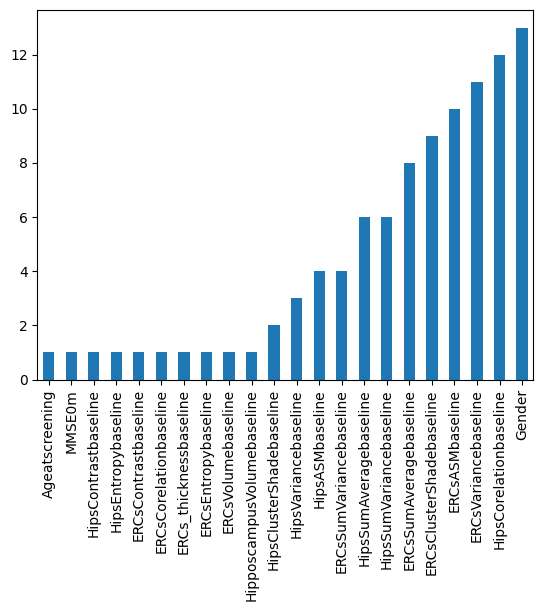

In [12]:
ranking = sel.ranking_
plot_ranking = pd.Series(ranking)
plot_ranking.index = X_train.columns
plot_ranking.sort_values().plot(kind="bar")

In [13]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((366, 10), (158, 10))

## Classification Test

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
                
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "ANOVA",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [15]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_missForest_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

In [16]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
ANOVA             Random Forest       balanced_accuracy 0.534    22                   0.925   
                                                        0.479    9                    0.901   
                  XGBoost             balanced_accuracy 0.854    22                   1.000   
                                                        0.457    9                    1.000   
                  NGBoost             balanced_accuracy 1.834    22                   0.868   
                                                        1.296    9                    0.858   
                  Logistic Regression balanced_accuracy 0.042    22                   0.801   
                                                        0.024    9                    0.771   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.534    22                  0.011   
                                                        0.479    9                   0.010   
                  XGBoost             balanced_accuracy 0.854    22                  0.000   
                                                        0.457    9                   0.000   
                  NGBoost             balanced_accuracy 1.834    22                  0.010   
                                                        1.296    9                   0.007   
                  Logistic Regression balanced_accuracy 0.042    22                  0.010   
                                                        0.024    9                   0.008   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.534    22                  0.711   
                                                        0.479    9                   0.746   
                  XGBoost             balanced_accuracy 0.854    22                  0.750   
                                                        0.457    9                   0.717   
                  NGBoost             balanced_accuracy 1.834    22                  0.756   
                                                        1.296    9                   0.752   
                  Logistic Regression balanced_accuracy 0.042    22                  0.751   
                                                        0.024    9                   0.739   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
ANOVA             Random Forest       balanced_accuracy 0.534    22                 0.080  
                                                        0.479    9                  0.061  
                  XGBoost             balanced_accuracy 0.854    22                 0.060  
                                                        0.457    9                  0.055  
                  NGBoost             balanced_accuracy 1.834    22                 0.050  
                                                        1.296    9                  0.063  
                  Logistic Regression balanced_accuracy 0.042    22                 0.051  
                                                        0.024    9                  0.057

In [17]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [18]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [19]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)
        
        if classifier_name == "Logistic Regression":  
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=100,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [20]:
results = "all"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                          
Boruta            Random Forest       0.264               22             accuracy                0.893   
                                                                         balanced_accuracy       0.907   
                                                                         precision_macro         0.900   
                                                                         recall_macro            0.907   
                                                                         f1_macro                0.900   
                                                                         roc_auc_macro           0.987   
                                                                         specificity_macro       0.945   
                                      0.181               9              accuracy                0.893   
                                                                         balanced_accuracy       0.904   
                                                                         precision_macro         0.903   
                                                                         recall_macro            0.904   
                                                                         f1_macro                0.902   
                                                                         roc_auc_macro           0.979   
                                                                         specificity_macro       0.944   
                  XGBoost             0.162               22             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                                      0.103               9              accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                  NGBoost             0.641               22             accuracy                0.869   
                                                                         balanced_accuracy       0.879   
                                                                         precision_macro         0.872   
                                                                         recall_macro            0.879   
                                                                         f1_macro                0.875   
                                                                         roc_auc_macro           0.970   
                                                                         specificity_macro       0.932   
                                      0.738               9              accuracy                0.842   
                                                                